In [48]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

# Define a convolution neural network
class CNN(nn.Module):
    def __init__(self, dropout_rate =0.5, weight_decay=1e-4):
        super(CNN, self).__init__()
        #include the batch normalization and max pooling in accounting for overfitting
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(24*10*10, 10)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.weight_decay = weight_decay

    def forward(self, input):
        #compute value of the loss function
        output = F.relu(self.bn1(self.conv1(input)))      
        output = F.relu(self.bn2(self.conv2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.conv4(output)))     
        output = F.relu(self.bn5(self.conv5(output)))     
        output = self.flatten(output)
        output = self.dropout(output)
        output = self.fc1(output)

        return output


In [ ]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

# Loading and normalizing the data.
# Define transformations for the images 
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

number_of_labels = 10 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create an instance for training. 
# When we run this code for the first time, the CIFAR10 train dataset will be downloaded locally. 
train_dataset =CIFAR10(root="./data",train=True,transform=transformations,download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)

test_dataset = CIFAR10(root="./data", train=False, transform=transformations, download=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


In [37]:
len(train_dataset)

50000

In [49]:
from torch.optim import Adam
from torch.optim import SGD

# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
# Instantiate a neural network model 
rate= 0.5
model = CNN(dropout_rate=rate)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer2 = SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)


In [ ]:
def saveModel():
    path = "./CIFAR-10Model.pth"
    torch.save(model.state_dict(), path)

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def show_loss(loss_list):
    epochs = np.arange(1, len(loss_list)+1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss_list, label='Training Loss', marker='o')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [71]:
def plot_uncertainty(pred_mean, pred_variance, epoch):
    # Plot the predictive mean

    # Generate x-axis values (epochs)
    classes = np.arange(1, 11)
    new_pred_mean = np.array(pred_mean)
    new_pred_variance = np.array(pred_variance)
    # Plot predictive mean
    plt.plot(classes, new_pred_mean, marker='o', linestyle='-', color='b', label='Predictive Mean')

    # Plot uncertainty as a filled area
    plt.fill_between(classes, new_pred_mean - np.sqrt(new_pred_variance), new_pred_mean + np.sqrt(new_pred_variance),
                 color='blue', alpha=0.2, label='Uncertainty Estimation')

    # Add labels and title
    plt.xlabel('Class')
    plt.ylabel('Predictive Mean and Uncertainty')
    plt.title('Predictive Mean and Uncertainty Estimation Over Epochs ' + str(epoch+1))
    plt.legend()

    # Show the plot
    plt.show()

[1,  1000] loss: 0.281
average training loss: 0.1273375953847372
For epoch 1 the test accuracy over the whole test set is 67 %
Predictive mean for epoch 1 10
Uncertainty estimation for epoch 1 10


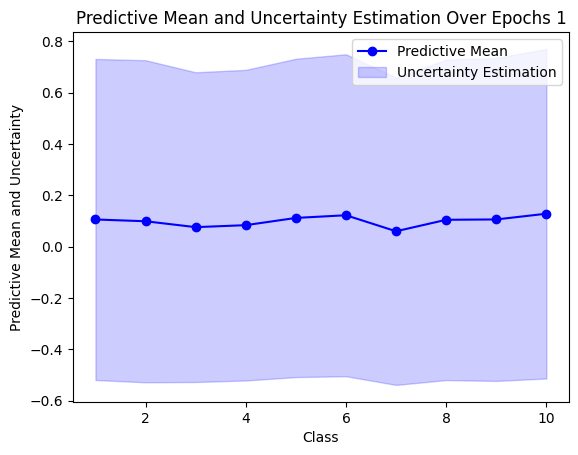

[2,  1000] loss: 0.274
average training loss: 0.11994789495720973
For epoch 2 the test accuracy over the whole test set is 67 %
Predictive mean for epoch 2 10
Uncertainty estimation for epoch 2 10


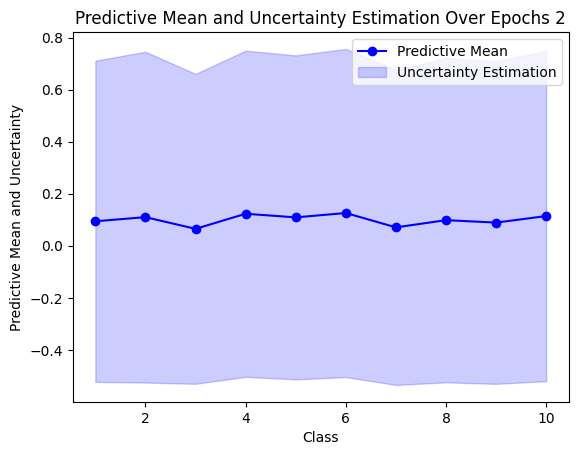

[3,  1000] loss: 0.267
average training loss: 0.11423558120926221
For epoch 3 the test accuracy over the whole test set is 67 %
Predictive mean for epoch 3 10
Uncertainty estimation for epoch 3 10


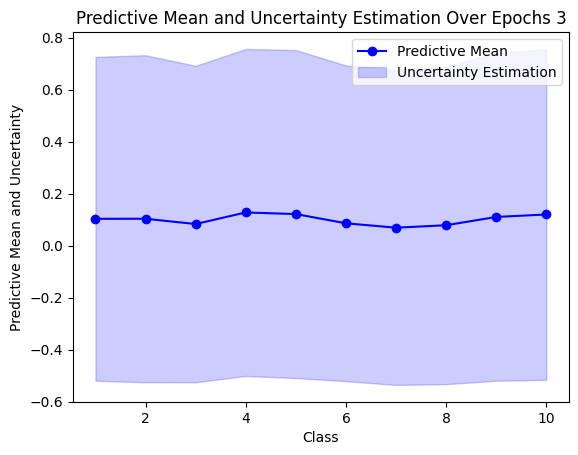

[4,  1000] loss: 0.251
average training loss: 0.1120135520995426
For epoch 4 the test accuracy over the whole test set is 67 %
Predictive mean for epoch 4 10
Uncertainty estimation for epoch 4 10


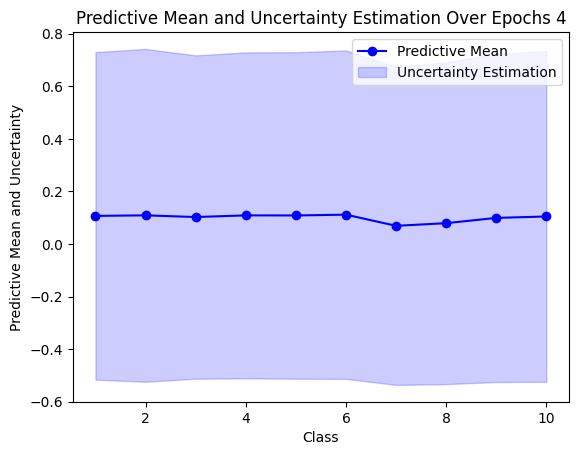

[5,  1000] loss: 0.231
average training loss: 0.11004529583076599
For epoch 5 the test accuracy over the whole test set is 67 %
Predictive mean for epoch 5 10
Uncertainty estimation for epoch 5 10


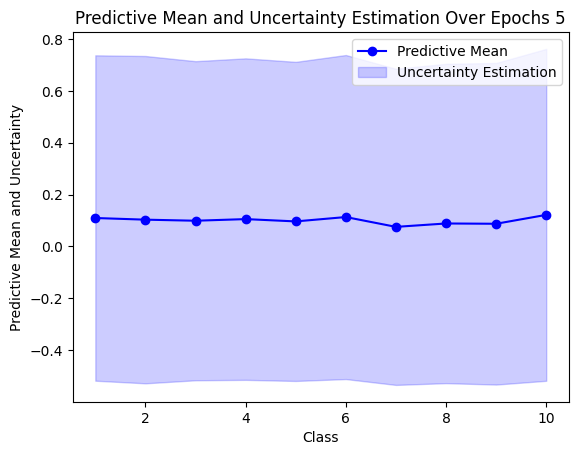

In [72]:

best_accuracy = 0.0
train_loss = []

for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    running_acc = 0.0

    for i, (images, labels) in enumerate(train_loader):
        
        # get the inputs
        # images = Variable(images.to(device))
        # labels = Variable(labels.to(device))

        # zero the parameter gradients
        optimizer.zero_grad()
        # predict classes using images from the training set
        outputs = model(images)
        # compute the loss based on model output and real labels
        loss = loss_fn(outputs, labels)
        # backpropagate the loss
        loss.backward()
        # adjust parameters based on the calculated gradients
        optimizer.step()

        # Let's print statistics for every 1,000 images
        running_loss += loss.item()     # extract the loss value
        if i % 1000 == 999:    
            # print every 1000 (twice per epoch) 
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 1000))
            # zero the loss
            running_loss = 0.0
    avg_train_loss =  running_loss / len(train_loader)
    print('average training loss: ' + str(avg_train_loss))
    train_loss.append(avg_train_loss)
       
    model.eval()
    accuracy = 0.0
    total = 0.0
    probs = []
    max_len = 0
    #compare with the test set 
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

            #softmax due to our image classification task 
            probs.append(outputs.softmax(dim=1).numpy())
            max_len = max(max_len, outputs.shape[1])
    #give the percentage accuracy 
    accuracy = (100 * accuracy / total)
    print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
    
    l = 8
    N = 50000
    for i in range(len(probs)):
        current_len = probs[i].shape[0]
        if current_len < max_len:
            # Pad with zeros
            padding = max_len - current_len
            probs[i] = np.concatenate((probs[i], np.zeros((padding,))))
        elif current_len > max_len:
            # Trim
            probs[i] = probs[i][:max_len]
    #will produce a list with 10 lists each present the predictive mean for each class
    predictive_mean = np.mean(probs, axis=0)
    #similar to the predictive mean
    predictive_variance = np.var(probs, axis=0)
    tau = l**2 * (1 - model.dropout.p) / (2 * N * model.weight_decay)
    predictive_variance += tau**-1

    print("Predictive mean for epoch", epoch+1, len(predictive_mean[0]))
    print("Uncertainty estimation for epoch", epoch+1, len(predictive_variance[0]))
    #plot the uncertainty over predicitve mean on each epochs (iterations **)
    plot_uncertainty(predictive_mean[0], predictive_variance[0], epoch)

    if accuracy > best_accuracy:
        saveModel()
        best_accuracy = accuracy



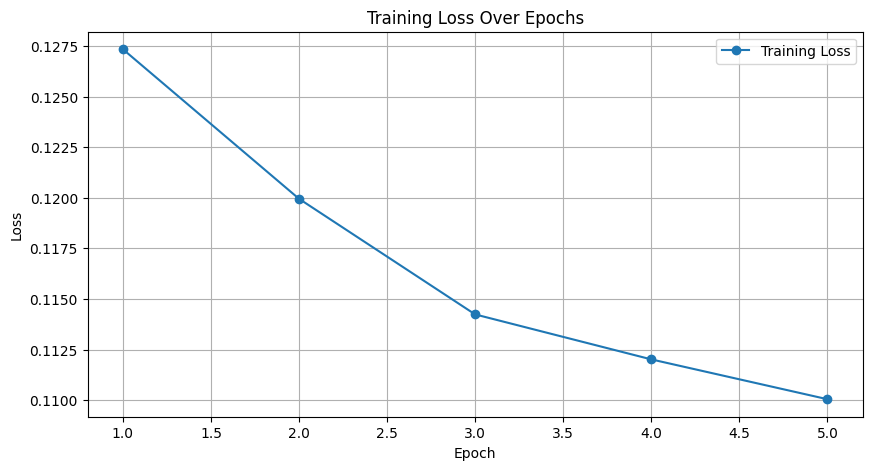

In [73]:
show_loss(train_loss)